# DARABASS Project notebook

## First let's analyse sound

import libraries. we're gonna use Librosa as the one related to sound

In [31]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import spectrogram
import soundfile as sf
from pathlib import Path
import sys
from IPython.display import Audio

# Add parent directory to path so utils can be found
sys.path.insert(0, str(Path.cwd().parent))

from utils.multilangual import translate

from tensorflow import keras

2025-12-08 16:20:30.601036: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 16:20:30.719157: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 16:20:34.265047: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Some Infos about our dataset : IDMT SMT audio effects dataset from Zenodo : 

 The overall duration of the audio material is approx. 30 hours. 
 The dataset consists of 55044 WAV files (44.1 kHz, 16bit) with single recorded 
notes: 

 20592 monophonic bass notes 

 20592 monophonic guitar notes 

 13860 polyphonic guitar sounds 

 Overall, 11 different audio effects are incorporated: 
o feedback delay 
o slapback delay 
o reverb 
o chorus 
o flanger 
o phaser 
o tremolo 
o vibrato 
o distortion 
o overdrive 
o no effect (unprocessed notes / sounds) 

but we'll get back to it.

##### Sample

Let's load a sample, and try to identify whet we can learn from it

In [4]:
audio_file = Path('Sample.wav')  # File is in the same directory as the notebook
waveform, sampling_rate = librosa.load(str(audio_file), sr=None)
print(f'Sampling Rate: {sampling_rate} Hz')

Sampling Rate: 44100 Hz


Let's play our sample at different speed aka Sampling Rate

In [17]:
Audio(waveform, rate=sampling_rate)

In [18]:
Audio(waveform, rate=sampling_rate*2)

In [19]:
Audio(waveform, rate=sampling_rate/2)

Let's import a dictionnary of Notes, on a bass guitar and their frequences and add a Fr column.

In [15]:
csv = Path('/home/edgar/code/Arkyed/08-Project/databass-code/DataBass/table_correspondance_notes_basse.csv')

table_correspondance = pd.read_csv(csv)
table_correspondance['noteFr'] = table_correspondance['note'].apply(lambda x : translate(x,'français'))
#table_correspondance.to_csv(csv)

,corde,case,note,fréquence (Hz),noteFr
0,E,0,E1,41.20,mi
1,E,1,F1,43.65,fa
2,E,2,F♯1,46.25,fa♯
3,E,3,G1,49.00,sol
4,E,4,G♯1,51.91,sol♯
...,...,...,...,...,...
95,G,20,D♯4,311.13,ré♯
96,G,21,E4,329.63,mi
97,G,22,F4,349.23,fa
98,G,23,F♯4,370.00,fa♯


Amplitude: It is the intensity of an audio signal at a particular point of time which corresponds to the height of the waveform at that instant of time. The amplitude is measured in decibels (dB). Human perceive amplitude of the sound wave as loudness. A rock concert can be around 125 dB, which is louder than a regular speaking voice and outside the range of human hearing.

Bit depth: How precisely this amplitude value can be defined depends on the bit depth of the sample. The digital representation more closely resembles the actual continuous sound wave the higher the bit depth. Higher bit depth results better audio quality. For common audio files Bit depths can be 8 bits, 16 bits or 24 bits. We will print the amplitude range by subtracting maximum amplitude and minimum amplitude levels.

In [20]:
# Compute the amplitude range
amplitude_range = np.max(waveform) - np.min(waveform)
# Get the bit depth from the audio data
audio_data, sampling_rate = sf.read(audio_file)
bit_depth = audio_data.dtype.itemsize
# printing values
print(f'Amplitude Range: {amplitude_range}')
print(f'Bit Depth: {bit_depth} bits')

Amplitude Range: 0.419769287109375
Bit Depth: 8 bits


#### Plot the waveform (Time Domain) Representation

A waveform is the graphical representation of of an audio signal in the time domain where each point on the waveform represents the amplitude of the audio signal at a specific point in time. It will help us to understand how the audio signal varies over time by its revealing features like sound duration, pauses and amplitude changes.

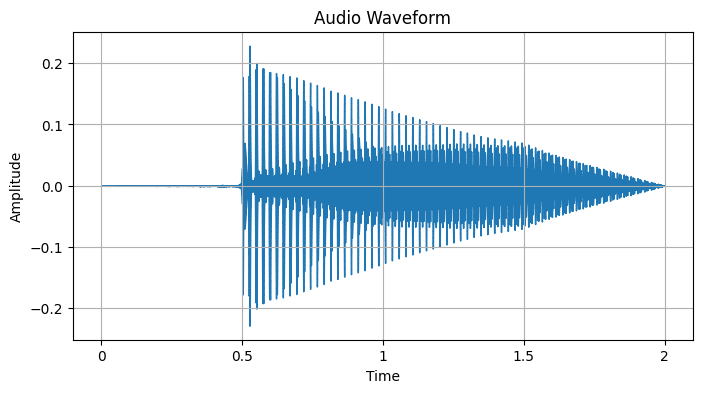

In [21]:
# Plot the waveform
## set size
plt.figure(figsize=(8, 4))

## Display the waveform of the adio signal
librosa.display.waveshow(waveform, sr = sampling_rate)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.grid(True)
plt.show()

#### Visualizing Frequency Spectrum
Frequency Spectrum is a representation of how the energy in an audio signal is distributed across different frequencies which can be calculated by applying a mathematical transformation like the Fast Fourier Transform (FFT) to the audio signal. It is very useful for identifying musical notes, detecting harmonics or filtering specific frequency components.

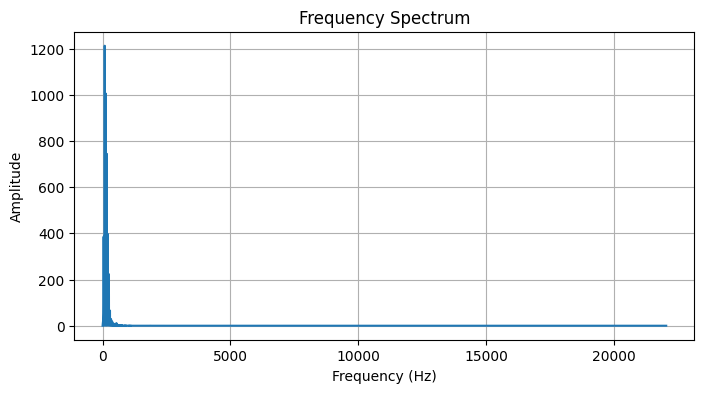

In [22]:
# Compute the FFT of the waveform
spectrum = fft(waveform)

# Frequency bins
frequencies = np.fft.fftfreq(len(spectrum), 1 / sampling_rate)

# Plot the frequency spectrum
plt.figure(figsize=(8, 4))
plt.plot(frequencies[:len(frequencies)//2], np.abs(spectrum[:len(spectrum)//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum')
plt.grid(True)
plt.show()

##### Spectrogram

Spectrogram is a time-frequency representation of an audio signal which provides a 2D visualization of how the frequency content of the audio signal changes over time.

In spectrogram, the dark regions indicate less presence of a frequency and in the other hand bright regions indicate strong presence of a frequency at a certain time. This will help is various tasks like speech recognition, musical analysis and identifying sound patterns.

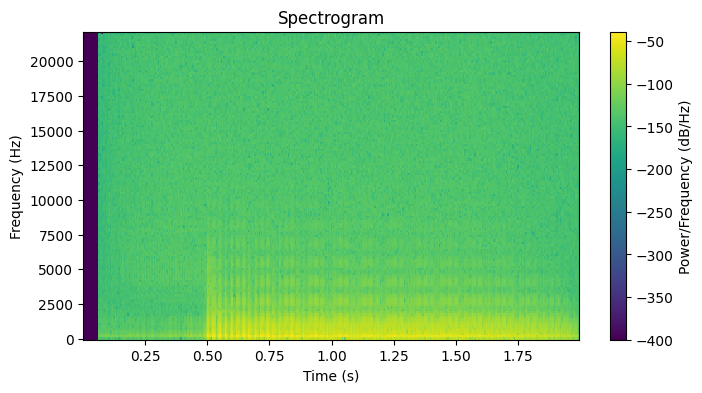

In [23]:
# Compute the spectrogram

# Small constant to avoid division by zero(if any)
epsilon = 1e-40
f, t, Sxx = spectrogram(waveform, fs=sampling_rate)

# Plot the spectrogram with the constant added to Sxx
plt.figure(figsize=(8, 4))
plt.pcolormesh(t, f, 10 * np.log10(Sxx + epsilon))
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.show()

In [25]:
chroma_orig = librosa.feature.chroma_cqt(y=waveform, sr=sampling_rate)

/home/edgar/.pyenv/versions/DataBass/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


Audio duration: 2.0000226757369615 seconds


[Text(0, 0.5, 'Default chroma')]

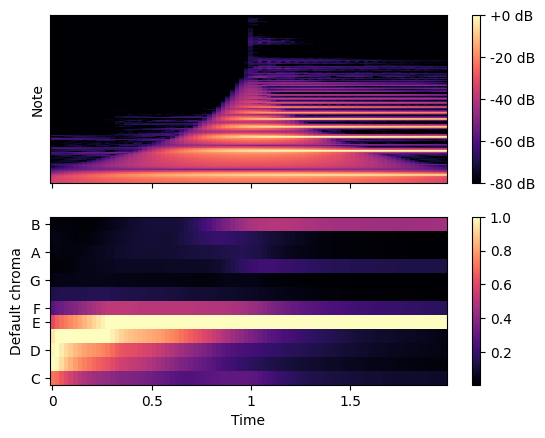

In [29]:
# Get actual audio duration in seconds
duration = librosa.get_duration(y=waveform, sr=sampling_rate)
print(f"Audio duration: {duration} seconds")

# Use a time window within bounds
start_time = min(5, duration - 15)  # Start at 5s or as close as possible
end_time = min(start_time + 15, duration)  # 15-second window

idx = tuple([slice(None), slice(*list(librosa.time_to_frames([start_time, end_time])))])

# And for comparison, we'll show the CQT matrix as well.
C = np.abs(librosa.cqt(y=waveform, sr=sampling_rate, bins_per_octave=12*3, n_bins=7*12*3))


fig, ax = plt.subplots(nrows=2, sharex=True)
img1 = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max)[idx],
                                y_axis='cqt_note', x_axis='time', bins_per_octave=12*3,
                                ax=ax[0])
fig.colorbar(img1, ax=[ax[0]], format="%+2.f dB")
ax[0].label_outer()

img2 = librosa.display.specshow(chroma_orig[idx], y_axis='chroma', x_axis='time', ax=ax[1])
fig.colorbar(img2, ax=[ax[1]])
ax[1].set(ylabel='Default chroma')

But that's only for ONE note. We're gonna need to split our audio into multiple segments, each containing one note.

In [ ]:
import os
import librosa

from pydub import AudioSegment

def decouper_audio_note_par_note(fichier_audio, dossier_sortie="notes"):
    try:
        # Charger l'audio avec librosa
        y, sr = librosa.load(fichier_audio, sr=None)  # sr=None pour garder la fréquence d'origine

        # Détection des onsets (début des notes)
        onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')
        print(f"Nombre de notes détectées : {len(onsets)}")

        # Charger aussi avec pydub pour découper
        audio = AudioSegment.from_file(fichier_audio)

        # Créer le dossier de sortie
        os.makedirs(dossier_sortie, exist_ok=True)

        # Découper chaque segment
        for i in range(len(onsets)):
            start_ms = int(onsets[i] * 1000)  # en millisecondes
            end_ms = int(onsets[i+1] * 1000) if i+1 < len(onsets) else len(audio)

            segment = audio[start_ms:end_ms]
            nom_fichier = os.path.join(dossier_sortie, f"note_{i+1}.wav")
            segment.export(nom_fichier, format="wav")
            print(f"Note {i+1} sauvegardée : {nom_fichier}")

        print("Découpage terminé.")

    except Exception as e:
        print(f"Erreur : {e}")

# Exemple d'utilisation
if __name__ == "__main__":
    fichier = "HappBDay.wav"  # Remplacez par votre fichier
    #decouper_audio_note_par_note(fichier)

Nombre de notes détectées : 25
Note 1 sauvegardée : notes/note_1.wav
Note 2 sauvegardée : notes/note_2.wav
Note 3 sauvegardée : notes/note_3.wav
Note 4 sauvegardée : notes/note_4.wav
Note 5 sauvegardée : notes/note_5.wav
Note 6 sauvegardée : notes/note_6.wav
Note 7 sauvegardée : notes/note_7.wav
Note 8 sauvegardée : notes/note_8.wav
Note 9 sauvegardée : notes/note_9.wav
Note 10 sauvegardée : notes/note_10.wav
Note 11 sauvegardée : notes/note_11.wav
Note 12 sauvegardée : notes/note_12.wav
Note 13 sauvegardée : notes/note_13.wav
Note 14 sauvegardée : notes/note_14.wav
Note 15 sauvegardée : notes/note_15.wav
Note 16 sauvegardée : notes/note_16.wav
Note 17 sauvegardée : notes/note_17.wav
Note 18 sauvegardée : notes/note_18.wav
Note 19 sauvegardée : notes/note_19.wav
Note 20 sauvegardée : notes/note_20.wav
Note 21 sauvegardée : notes/note_21.wav
Note 22 sauvegardée : notes/note_22.wav
Note 23 sauvegardée : notes/note_23.wav
Note 24 sauvegardée : notes/note_24.wav
Note 25 sauvegardée : notes